##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 理解语言的 Transformer 模型

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/text/transformer">
    <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />
    在 tensorflow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/transformer.ipynb">
    <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />
    在 Google Colab 运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/transformer.ipynb">
    <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />
    在 Github 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/text/transformer.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载此 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://tensorflow.google.cn/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)

本教程训练了一个 <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer 模型</a> 用于将葡萄牙语翻译成英语。这是一个高级示例，假定您具备[文本生成（text generation）](text_generation.ipynb)和 [注意力机制（attention）](nmt_with_attention.ipynb) 的知识。

Transformer 模型的核心思想是*自注意力机制（self-attention）*——能注意输入序列的不同位置以计算该序列的表示的能力。Transformer 创建了多层自注意力层（self-attetion layers）组成的堆栈，下文的*按比缩放的点积注意力（Scaled dot product attention）*和*多头注意力（Multi-head attention）*部分对此进行了说明。

一个 transformer 模型用自注意力层而非 [RNNs](text_classification_rnn.ipynb) 或 [CNNs](../images/intro_to_cnns.ipynb) 来处理变长的输入。这种通用架构有一系列的优势：

* 它不对数据间的时间/空间关系做任何假设。这是处理一组对象（objects）的理想选择（例如，[星际争霸单位（StarCraft units）](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)）。
* 层输出可以并行计算，而非像 RNN 这样的序列计算。
* 远距离项可以影响彼此的输出，而无需经过许多 RNN 步骤或卷积层（例如，参见[场景记忆 Transformer（Scene Memory Transformer）](https://arxiv.org/pdf/1903.03878.pdf)）
* 它能学习长距离的依赖。在许多序列任务中，这是一项挑战。

该架构的缺点是：

* 对于时间序列，一个单位时间的输出是从*整个历史记录*计算的，而非仅从输入和当前的隐含状态计算得到。这*可能*效率较低。   
* 如果输入*确实*有时间/空间的关系，像文本，则必须加入一些位置编码，否则模型将有效地看到一堆单词。

在此 notebook 中训练完模型后，您将能输入葡萄牙语句子，得到其英文翻译。

<img src="https://tensorflow.google.cn/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## 设置输入流水线（input pipeline）

使用 [TFDS](https://tensorflow.google.cn/datasets) 来导入 [葡萄牙语-英语翻译数据集](https://github.com/neulab/word-embeddings-for-nmt)，该数据集来自于 [TED 演讲开放翻译项目](https://www.ted.com/participate/translate).

该数据集包含来约 50000 条训练样本，1100 条验证样本，以及 2000 条测试样本。

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3YLR59/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3YLR59/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3YLR59/ted_hrlr_translate-test.tfrecord
Dataset ted_hrlr_translate downloaded and prepared to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


从训练数据集创建自定义子词分词器（subwords tokenizer）。

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


如果单词不在词典中，则分词器（tokenizer）通过将单词分解为子词来对字符串进行编码。

In [6]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

将开始和结束标记（token）添加到输入和目标。

In [8]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

Note：为了使本示例较小且相对较快，删除长度大于40个标记的样本。

In [9]:
MAX_LENGTH = 40

In [10]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

`.map()` 内部的操作以图模式（graph mode）运行，`.map()` 接收一个不具有 numpy 属性的图张量（graph tensor）。该`分词器（tokenizer）`需要将一个字符串或 Unicode 符号，编码成整数。因此，您需要在 `tf.py_function` 内部运行编码过程，`tf.py_function` 接收一个 eager 张量，该 eager 张量有一个包含字符串值的 numpy 属性。

In [11]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [12]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [13]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置编码（Positional encoding）

因为该模型并不包括任何的循环（recurrence）或卷积，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。

位置编码向量被加到嵌入（embedding）向量中。嵌入表示一个 d 维空间的标记，在 d 维空间中有着相似含义的标记会离彼此更近。但是，嵌入并没有对在一句话中的词的相对位置进行编码。因此，当加上位置编码后，词将基于*它们含义的相似度以及它们在句子中的位置*，在 d 维空间中离彼此更近。

参看 [位置编码](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) 的 notebook 了解更多信息。计算位置编码的公式如下：

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [14]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [15]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # 将 sin 应用于数组中的偶数索引（indices）；2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # 将 cos 应用于数组中的奇数索引；2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


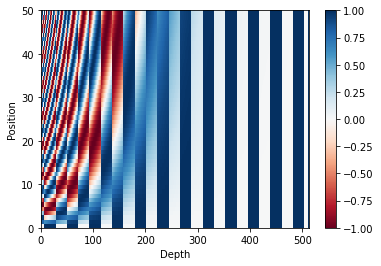

In [16]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。这确保了模型不会将填充作为输入。该 mask 表明填充值 `0` 出现的位置：在这些位置 mask 输出 `1`，否则输出 `0`。

In [17]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # 添加额外的维度来将填充加到
  # 注意力对数（logits）。
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [18]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）。换句话说，该 mask 表明了不应该使用的条目。

这意味着要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。 

In [19]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [20]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 按比缩放的点积注意力（Scaled dot product attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformer 使用的注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））。用于计算注意力权重的等式为：

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

点积注意力被缩小了深度的平方根倍。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 `Q` 和 `K` 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 `dk`。因此，*`dk` 的平方根*被用于缩放（而非其他数值），因为，`Q` 和 `K` 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax。

遮挡（mask）与 -1e9（接近于负无穷）相乘。这样做是因为遮挡与缩放的 Q 和 K 的矩阵乘积相加，并在 softmax 之前立即应用。目标是将这些单元归零，因为 softmax 的较大负数输入在输出中接近于零。

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
  """计算注意力权重。
  q, k, v 必须具有匹配的前置维度。
  k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
  虽然 mask 根据其类型（填充或前瞻）有不同的形状，
  但是 mask 必须能进行广播转换以便求和。
  
  参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。
    
  返回值:
    输出，注意力权重
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # 缩放 matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # 将 mask 加入到缩放的张量上。
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
  # 相加等于1。
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

当 softmax 在 K 上进行归一化后，它的值决定了分配到 Q 的重要程度。

输出表示注意力权重和 V（数值）向量的乘积。这确保了要关注的词保持原样，而无关的词将被清除掉。

In [22]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [23]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [24]:
# 这条请求符合重复出现的主键（第三第四个），
# 因此，对所有的相关数值取了平均。
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [25]:
# 这条请求符合第一和第二条主键，
# 因此，对它们的数值去了平均。
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


将所有请求一起*传递*。

In [26]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 多头注意力（Multi-head attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


多头注意力由四部分组成：
*    线性层并分拆成多头。
*    按比缩放的点积注意力。
*    多头及联。
*    最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。 

将上面定义的 `scaled_dot_product_attention` 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用`tf.transpose` 和 `tf.reshape`），并放入最后的 `Dense` 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """分拆最后一个维度到 (num_heads, depth).
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

创建一个 `MultiHeadAttention` 层进行尝试。在序列中的每个位置 `y`，`MultiHeadAttention` 在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量。

In [28]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## 点式前馈网络（Point wise feed forward network）

点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。

In [29]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [30]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## 编码与解码（Encoder and decoder）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Transformer 模型与标准的[具有注意力机制的序列到序列模型（sequence to sequence with attention model）](nmt_with_attention.ipynb)，遵循相同的一般模式。

* 输入语句经过 `N` 个编码器层，为序列中的每个词/标记生成一个输出。
* 解码器关注编码器的输出以及它自身的输入（自注意力）来预测下一个词。

### 编码器层（Encoder layer）

每个编码器层包括以下子层：

1.   多头注意力（有填充遮挡）
2.   点式前馈网络（Point wise feed forward networks）。

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。Transformer 中有 N 个编码器层。

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [32]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### 解码器层（Decoder layer）

每个解码器层包括以下子层：

1.   遮挡的多头注意力（前瞻遮挡和填充遮挡）
2.   多头注意力（用填充遮挡）。V（数值）和 K（主键）接收*编码器输出*作为输入。Q（请求）接收*遮挡的多头注意力子层的输出*。
3.   点式前馈网络

每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词。参看按比缩放的点积注意力部分的演示。

In [33]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [34]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### 编码器（Encoder）

`编码器` 包括：
1.   输入嵌入（Input Embedding）
2.   位置编码（Positional Encoding）
3.   N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。

In [35]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # 将嵌入和位置编码相加。
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [36]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### 解码器（Decoder）

`解码器`包括：
1.   输出嵌入（Output Embedding）
2.   位置编码（Positional Encoding）
3.   N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [37]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [38]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## 创建 Transformer

Transformer 包括编码器，解码器和最后的线性层。解码器的输出是线性层的输入，返回线性层的输出。

In [39]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [40]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

## 配置超参数（hyperparameters）

为了让本示例小且相对较快，已经减小了*num_layers、 d_model 和  dff* 的值。 

Transformer 的基础模型使用的数值为：*num_layers=6*，*d_model = 512*，*dff = 2048*。关于所有其他版本的 Transformer，请查阅[论文](https://arxiv.org/abs/1706.03762)。

Note：通过改变以下数值，您可以获得在许多任务上达到最先进水平的模型。

In [41]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## 优化器（Optimizer）

根据[论文](https://arxiv.org/abs/1706.03762)中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [42]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [43]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

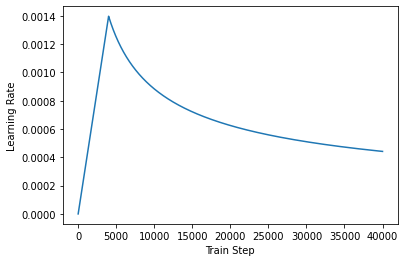

In [44]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 损失函数与指标（Loss and metrics）

由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。

In [45]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [46]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [47]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 训练与检查点（Training and checkpointing）

In [48]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [49]:
def create_masks(inp, tar):
  # 编码器填充遮挡
  enc_padding_mask = create_padding_mask(inp)
  
  # 在解码器的第二个注意力模块使用。
  # 该填充遮挡用于遮挡编码器的输出。
  dec_padding_mask = create_padding_mask(inp)
  
  # 在解码器的第一个注意力模块使用。
  # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

创建检查点的路径和检查点管理器（manager）。这将用于在每 `n` 个周期（epochs）保存检查点。

In [50]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

目标（target）被分成了 tar_inp 和 tar_real。tar_inp 作为输入传递到解码器。`tar_real` 是位移了 1 的同一个输入：在 `tar_inp` 中的每个位置，`tar_real` 包含了应该被预测到的下一个标记（token）。

例如，`sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Transformer 是一个自回归（auto-regressive）模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，本示例使用了 teacher-forcing 的方法（就像[文本生成教程](./text_generation.ipynb)中一样）。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 transformer 预测每个词时，*自注意力（self-attention）*功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

为了防止模型在期望的输出上达到峰值，模型使用了前瞻遮挡（look-ahead mask）。

In [51]:
EPOCHS = 20

In [52]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

葡萄牙语作为输入语言，英语为目标语言。

In [53]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.3163 Accuracy 0.0004


Epoch 1 Batch 50 Loss 4.2825 Accuracy 0.0018


Epoch 1 Batch 100 Loss 4.2022 Accuracy 0.0134


Epoch 1 Batch 150 Loss 4.1526 Accuracy 0.0180


Epoch 1 Batch 200 Loss 4.0717 Accuracy 0.0204


Epoch 1 Batch 250 Loss 3.9939 Accuracy 0.0224


Epoch 1 Batch 300 Loss 3.9193 Accuracy 0.0242


Epoch 1 Batch 350 Loss 3.8341 Accuracy 0.0264


Epoch 1 Batch 400 Loss 3.7555 Accuracy 0.0301


Epoch 1 Batch 450 Loss 3.6772 Accuracy 0.0335


Epoch 1 Batch 500 Loss 3.6066 Accuracy 0.0367


Epoch 1 Batch 550 Loss 3.5419 Accuracy 0.0403


Epoch 1 Batch 600 Loss 3.4774 Accuracy 0.0440


Epoch 1 Batch 650 Loss 3.4262 Accuracy 0.0476


Epoch 1 Batch 700 Loss 3.3708 Accuracy 0.0510
Epoch 1 Loss 3.3693 Accuracy 0.0512
Time taken for 1 epoch: 60.16580581665039 secs

Epoch 2 Batch 0 Loss 2.5117 Accuracy 0.1003


Epoch 2 Batch 50 Loss 2.5981 Accuracy 0.1028


Epoch 2 Batch 100 Loss 2.5820 Accuracy 0.1058


Epoch 2 Batch 150 Loss 2.5412 Accuracy 0.1078


Epoch 2 Batch 200 Loss 2.5172 Accuracy 0.1099


Epoch 2 Batch 250 Loss 2.4793 Accuracy 0.1118


Epoch 2 Batch 300 Loss 2.4630 Accuracy 0.1138


Epoch 2 Batch 350 Loss 2.4430 Accuracy 0.1156


Epoch 2 Batch 400 Loss 2.4333 Accuracy 0.1174


Epoch 2 Batch 450 Loss 2.4241 Accuracy 0.1191


Epoch 2 Batch 500 Loss 2.4140 Accuracy 0.1207


Epoch 2 Batch 550 Loss 2.4004 Accuracy 0.1220


Epoch 2 Batch 600 Loss 2.3853 Accuracy 0.1232


Epoch 2 Batch 650 Loss 2.3757 Accuracy 0.1244


Epoch 2 Batch 700 Loss 2.3634 Accuracy 0.1255
Epoch 2 Loss 2.3630 Accuracy 0.1255
Time taken for 1 epoch: 31.393303871154785 secs

Epoch 3 Batch 0 Loss 2.0532 Accuracy 0.1424


Epoch 3 Batch 50 Loss 2.1493 Accuracy 0.1433


Epoch 3 Batch 100 Loss 2.1437 Accuracy 0.1437


Epoch 3 Batch 150 Loss 2.1445 Accuracy 0.1448


Epoch 3 Batch 200 Loss 2.1471 Accuracy 0.1451


Epoch 3 Batch 250 Loss 2.1426 Accuracy 0.1458


Epoch 3 Batch 300 Loss 2.1416 Accuracy 0.1466


Epoch 3 Batch 350 Loss 2.1400 Accuracy 0.1476


Epoch 3 Batch 400 Loss 2.1315 Accuracy 0.1480


Epoch 3 Batch 450 Loss 2.1271 Accuracy 0.1483


Epoch 3 Batch 500 Loss 2.1217 Accuracy 0.1488


Epoch 3 Batch 550 Loss 2.1167 Accuracy 0.1492


Epoch 3 Batch 600 Loss 2.1111 Accuracy 0.1497


Epoch 3 Batch 650 Loss 2.1069 Accuracy 0.1502


Epoch 3 Batch 700 Loss 2.1020 Accuracy 0.1509
Epoch 3 Loss 2.1011 Accuracy 0.1509
Time taken for 1 epoch: 31.126026153564453 secs

Epoch 4 Batch 0 Loss 1.8764 Accuracy 0.1534


Epoch 4 Batch 50 Loss 1.9276 Accuracy 0.1609


Epoch 4 Batch 100 Loss 1.9371 Accuracy 0.1636


Epoch 4 Batch 150 Loss 1.9392 Accuracy 0.1644


Epoch 4 Batch 200 Loss 1.9391 Accuracy 0.1654


Epoch 4 Batch 250 Loss 1.9351 Accuracy 0.1660


Epoch 4 Batch 300 Loss 1.9323 Accuracy 0.1669


Epoch 4 Batch 350 Loss 1.9289 Accuracy 0.1675


Epoch 4 Batch 400 Loss 1.9238 Accuracy 0.1684


Epoch 4 Batch 450 Loss 1.9193 Accuracy 0.1692


Epoch 4 Batch 500 Loss 1.9146 Accuracy 0.1704


Epoch 4 Batch 550 Loss 1.9124 Accuracy 0.1714


Epoch 4 Batch 600 Loss 1.9038 Accuracy 0.1726


Epoch 4 Batch 650 Loss 1.8971 Accuracy 0.1735


Epoch 4 Batch 700 Loss 1.8924 Accuracy 0.1747
Epoch 4 Loss 1.8911 Accuracy 0.1746
Time taken for 1 epoch: 31.81874442100525 secs

Epoch 5 Batch 0 Loss 1.7212 Accuracy 0.1915


Epoch 5 Batch 50 Loss 1.7288 Accuracy 0.1948


Epoch 5 Batch 100 Loss 1.7079 Accuracy 0.1925


Epoch 5 Batch 150 Loss 1.7059 Accuracy 0.1940


Epoch 5 Batch 200 Loss 1.7098 Accuracy 0.1947


Epoch 5 Batch 250 Loss 1.7009 Accuracy 0.1953


Epoch 5 Batch 300 Loss 1.7049 Accuracy 0.1967


Epoch 5 Batch 350 Loss 1.7009 Accuracy 0.1975


Epoch 5 Batch 400 Loss 1.6954 Accuracy 0.1979


Epoch 5 Batch 450 Loss 1.6900 Accuracy 0.1985


Epoch 5 Batch 500 Loss 1.6858 Accuracy 0.1993


Epoch 5 Batch 550 Loss 1.6856 Accuracy 0.2002


Epoch 5 Batch 600 Loss 1.6810 Accuracy 0.2009


Epoch 5 Batch 650 Loss 1.6746 Accuracy 0.2016


Epoch 5 Batch 700 Loss 1.6698 Accuracy 0.2022


Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 1.6697 Accuracy 0.2022
Time taken for 1 epoch: 31.367265462875366 secs

Epoch 6 Batch 0 Loss 1.4858 Accuracy 0.2155


Epoch 6 Batch 50 Loss 1.4763 Accuracy 0.2153


Epoch 6 Batch 100 Loss 1.4967 Accuracy 0.2173


Epoch 6 Batch 150 Loss 1.4930 Accuracy 0.2183


Epoch 6 Batch 200 Loss 1.4938 Accuracy 0.2190


Epoch 6 Batch 250 Loss 1.5026 Accuracy 0.2205


Epoch 6 Batch 300 Loss 1.5025 Accuracy 0.2208


Epoch 6 Batch 350 Loss 1.4974 Accuracy 0.2208


Epoch 6 Batch 400 Loss 1.4984 Accuracy 0.2214


Epoch 6 Batch 450 Loss 1.4972 Accuracy 0.2220


Epoch 6 Batch 500 Loss 1.4940 Accuracy 0.2222


Epoch 6 Batch 550 Loss 1.4911 Accuracy 0.2223


Epoch 6 Batch 600 Loss 1.4896 Accuracy 0.2227


Epoch 6 Batch 650 Loss 1.4849 Accuracy 0.2231


Epoch 6 Batch 700 Loss 1.4819 Accuracy 0.2237
Epoch 6 Loss 1.4821 Accuracy 0.2237
Time taken for 1 epoch: 31.269275426864624 secs

Epoch 7 Batch 0 Loss 1.5062 Accuracy 0.2517


Epoch 7 Batch 50 Loss 1.3157 Accuracy 0.2398


Epoch 7 Batch 100 Loss 1.3275 Accuracy 0.2426


Epoch 7 Batch 150 Loss 1.3256 Accuracy 0.2413


Epoch 7 Batch 200 Loss 1.3212 Accuracy 0.2413


Epoch 7 Batch 250 Loss 1.3213 Accuracy 0.2424


Epoch 7 Batch 300 Loss 1.3195 Accuracy 0.2424


Epoch 7 Batch 350 Loss 1.3158 Accuracy 0.2425


Epoch 7 Batch 400 Loss 1.3112 Accuracy 0.2430


Epoch 7 Batch 450 Loss 1.3050 Accuracy 0.2432


Epoch 7 Batch 500 Loss 1.3025 Accuracy 0.2436


Epoch 7 Batch 550 Loss 1.3013 Accuracy 0.2441


Epoch 7 Batch 600 Loss 1.2981 Accuracy 0.2447


Epoch 7 Batch 650 Loss 1.2952 Accuracy 0.2447


Epoch 7 Batch 700 Loss 1.2947 Accuracy 0.2452
Epoch 7 Loss 1.2947 Accuracy 0.2453
Time taken for 1 epoch: 31.002289056777954 secs

Epoch 8 Batch 0 Loss 1.0162 Accuracy 0.2484


Epoch 8 Batch 50 Loss 1.1310 Accuracy 0.2597


Epoch 8 Batch 100 Loss 1.1398 Accuracy 0.2611


Epoch 8 Batch 150 Loss 1.1428 Accuracy 0.2607


Epoch 8 Batch 200 Loss 1.1476 Accuracy 0.2613


Epoch 8 Batch 250 Loss 1.1415 Accuracy 0.2614


Epoch 8 Batch 300 Loss 1.1396 Accuracy 0.2620


Epoch 8 Batch 350 Loss 1.1410 Accuracy 0.2625


Epoch 8 Batch 400 Loss 1.1397 Accuracy 0.2627


Epoch 8 Batch 450 Loss 1.1400 Accuracy 0.2629


Epoch 8 Batch 500 Loss 1.1387 Accuracy 0.2629


Epoch 8 Batch 550 Loss 1.1365 Accuracy 0.2632


Epoch 8 Batch 600 Loss 1.1360 Accuracy 0.2632


Epoch 8 Batch 650 Loss 1.1364 Accuracy 0.2636


Epoch 8 Batch 700 Loss 1.1345 Accuracy 0.2638
Epoch 8 Loss 1.1345 Accuracy 0.2638
Time taken for 1 epoch: 31.10622811317444 secs

Epoch 9 Batch 0 Loss 1.0940 Accuracy 0.3234


Epoch 9 Batch 50 Loss 1.0242 Accuracy 0.2814


Epoch 9 Batch 100 Loss 1.0237 Accuracy 0.2809


Epoch 9 Batch 150 Loss 1.0214 Accuracy 0.2797


Epoch 9 Batch 200 Loss 1.0180 Accuracy 0.2790


Epoch 9 Batch 250 Loss 1.0185 Accuracy 0.2787


Epoch 9 Batch 300 Loss 1.0184 Accuracy 0.2786


Epoch 9 Batch 350 Loss 1.0166 Accuracy 0.2780


Epoch 9 Batch 400 Loss 1.0162 Accuracy 0.2780


Epoch 9 Batch 450 Loss 1.0146 Accuracy 0.2775


Epoch 9 Batch 500 Loss 1.0163 Accuracy 0.2775


Epoch 9 Batch 550 Loss 1.0183 Accuracy 0.2778


Epoch 9 Batch 600 Loss 1.0188 Accuracy 0.2780


Epoch 9 Batch 650 Loss 1.0199 Accuracy 0.2781


Epoch 9 Batch 700 Loss 1.0234 Accuracy 0.2785
Epoch 9 Loss 1.0232 Accuracy 0.2785
Time taken for 1 epoch: 30.981273889541626 secs

Epoch 10 Batch 0 Loss 0.8119 Accuracy 0.2732


Epoch 10 Batch 50 Loss 0.9071 Accuracy 0.2880


Epoch 10 Batch 100 Loss 0.9160 Accuracy 0.2894


Epoch 10 Batch 150 Loss 0.9165 Accuracy 0.2896


Epoch 10 Batch 200 Loss 0.9201 Accuracy 0.2897


Epoch 10 Batch 250 Loss 0.9230 Accuracy 0.2895


Epoch 10 Batch 300 Loss 0.9252 Accuracy 0.2900


Epoch 10 Batch 350 Loss 0.9270 Accuracy 0.2900


Epoch 10 Batch 400 Loss 0.9254 Accuracy 0.2899


Epoch 10 Batch 450 Loss 0.9267 Accuracy 0.2895


Epoch 10 Batch 500 Loss 0.9302 Accuracy 0.2890


Epoch 10 Batch 550 Loss 0.9307 Accuracy 0.2889


Epoch 10 Batch 600 Loss 0.9322 Accuracy 0.2890


Epoch 10 Batch 650 Loss 0.9352 Accuracy 0.2892


Epoch 10 Batch 700 Loss 0.9375 Accuracy 0.2890


Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Loss 0.9379 Accuracy 0.2891
Time taken for 1 epoch: 31.26957678794861 secs

Epoch 11 Batch 0 Loss 0.8713 Accuracy 0.2925


Epoch 11 Batch 50 Loss 0.8490 Accuracy 0.3006


Epoch 11 Batch 100 Loss 0.8531 Accuracy 0.3021


Epoch 11 Batch 150 Loss 0.8443 Accuracy 0.3002


Epoch 11 Batch 200 Loss 0.8487 Accuracy 0.3003


Epoch 11 Batch 250 Loss 0.8535 Accuracy 0.2998


Epoch 11 Batch 300 Loss 0.8542 Accuracy 0.2999


Epoch 11 Batch 350 Loss 0.8569 Accuracy 0.2995


Epoch 11 Batch 400 Loss 0.8586 Accuracy 0.2991


Epoch 11 Batch 450 Loss 0.8596 Accuracy 0.2987


Epoch 11 Batch 500 Loss 0.8608 Accuracy 0.2984


Epoch 11 Batch 550 Loss 0.8628 Accuracy 0.2982


Epoch 11 Batch 600 Loss 0.8642 Accuracy 0.2980


Epoch 11 Batch 650 Loss 0.8671 Accuracy 0.2981


Epoch 11 Batch 700 Loss 0.8693 Accuracy 0.2982
Epoch 11 Loss 0.8693 Accuracy 0.2982
Time taken for 1 epoch: 32.054973125457764 secs

Epoch 12 Batch 0 Loss 0.7781 Accuracy 0.3277


Epoch 12 Batch 50 Loss 0.7705 Accuracy 0.3061


Epoch 12 Batch 100 Loss 0.7835 Accuracy 0.3090


Epoch 12 Batch 150 Loss 0.7882 Accuracy 0.3070


Epoch 12 Batch 200 Loss 0.7926 Accuracy 0.3069


Epoch 12 Batch 250 Loss 0.7952 Accuracy 0.3075


Epoch 12 Batch 300 Loss 0.7989 Accuracy 0.3073


Epoch 12 Batch 350 Loss 0.8016 Accuracy 0.3069


Epoch 12 Batch 400 Loss 0.8045 Accuracy 0.3073


Epoch 12 Batch 450 Loss 0.8063 Accuracy 0.3070


Epoch 12 Batch 500 Loss 0.8068 Accuracy 0.3066


Epoch 12 Batch 550 Loss 0.8099 Accuracy 0.3064


Epoch 12 Batch 600 Loss 0.8112 Accuracy 0.3060


Epoch 12 Batch 650 Loss 0.8122 Accuracy 0.3058


Epoch 12 Batch 700 Loss 0.8144 Accuracy 0.3057
Epoch 12 Loss 0.8140 Accuracy 0.3056
Time taken for 1 epoch: 30.988539934158325 secs

Epoch 13 Batch 0 Loss 0.6429 Accuracy 0.3097


Epoch 13 Batch 50 Loss 0.7236 Accuracy 0.3075


Epoch 13 Batch 100 Loss 0.7323 Accuracy 0.3110


Epoch 13 Batch 150 Loss 0.7314 Accuracy 0.3106


Epoch 13 Batch 200 Loss 0.7346 Accuracy 0.3115


Epoch 13 Batch 250 Loss 0.7388 Accuracy 0.3119


Epoch 13 Batch 300 Loss 0.7461 Accuracy 0.3129


Epoch 13 Batch 350 Loss 0.7477 Accuracy 0.3129


Epoch 13 Batch 400 Loss 0.7488 Accuracy 0.3127


Epoch 13 Batch 450 Loss 0.7526 Accuracy 0.3126


Epoch 13 Batch 500 Loss 0.7566 Accuracy 0.3129


Epoch 13 Batch 550 Loss 0.7606 Accuracy 0.3127


Epoch 13 Batch 600 Loss 0.7626 Accuracy 0.3124


Epoch 13 Batch 650 Loss 0.7644 Accuracy 0.3121


Epoch 13 Batch 700 Loss 0.7657 Accuracy 0.3122
Epoch 13 Loss 0.7658 Accuracy 0.3122
Time taken for 1 epoch: 31.11562490463257 secs

Epoch 14 Batch 0 Loss 0.6303 Accuracy 0.3125


Epoch 14 Batch 50 Loss 0.6793 Accuracy 0.3209


Epoch 14 Batch 100 Loss 0.6850 Accuracy 0.3220


Epoch 14 Batch 150 Loss 0.6885 Accuracy 0.3205


Epoch 14 Batch 200 Loss 0.6975 Accuracy 0.3208


Epoch 14 Batch 250 Loss 0.7003 Accuracy 0.3199


Epoch 14 Batch 300 Loss 0.7045 Accuracy 0.3197


Epoch 14 Batch 350 Loss 0.7081 Accuracy 0.3205


Epoch 14 Batch 400 Loss 0.7095 Accuracy 0.3197


Epoch 14 Batch 450 Loss 0.7120 Accuracy 0.3189


Epoch 14 Batch 500 Loss 0.7135 Accuracy 0.3186


Epoch 14 Batch 550 Loss 0.7167 Accuracy 0.3186


Epoch 14 Batch 600 Loss 0.7191 Accuracy 0.3183


Epoch 14 Batch 650 Loss 0.7215 Accuracy 0.3182


Epoch 14 Batch 700 Loss 0.7234 Accuracy 0.3179
Epoch 14 Loss 0.7238 Accuracy 0.3179
Time taken for 1 epoch: 30.928674936294556 secs

Epoch 15 Batch 0 Loss 0.5921 Accuracy 0.3298


Epoch 15 Batch 50 Loss 0.6525 Accuracy 0.3265


Epoch 15 Batch 100 Loss 0.6511 Accuracy 0.3255


Epoch 15 Batch 150 Loss 0.6618 Accuracy 0.3250


Epoch 15 Batch 200 Loss 0.6659 Accuracy 0.3244


Epoch 15 Batch 250 Loss 0.6658 Accuracy 0.3243


Epoch 15 Batch 300 Loss 0.6666 Accuracy 0.3241


Epoch 15 Batch 350 Loss 0.6695 Accuracy 0.3236


Epoch 15 Batch 400 Loss 0.6723 Accuracy 0.3237


Epoch 15 Batch 450 Loss 0.6759 Accuracy 0.3235


Epoch 15 Batch 500 Loss 0.6783 Accuracy 0.3238


Epoch 15 Batch 550 Loss 0.6800 Accuracy 0.3230


Epoch 15 Batch 600 Loss 0.6826 Accuracy 0.3226


Epoch 15 Batch 650 Loss 0.6850 Accuracy 0.3226


Epoch 15 Batch 700 Loss 0.6884 Accuracy 0.3225


Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Epoch 15 Loss 0.6887 Accuracy 0.3225
Time taken for 1 epoch: 31.319037675857544 secs

Epoch 16 Batch 0 Loss 0.5955 Accuracy 0.3319


Epoch 16 Batch 50 Loss 0.6032 Accuracy 0.3275


Epoch 16 Batch 100 Loss 0.6082 Accuracy 0.3308


Epoch 16 Batch 150 Loss 0.6231 Accuracy 0.3322


Epoch 16 Batch 200 Loss 0.6284 Accuracy 0.3314


Epoch 16 Batch 250 Loss 0.6318 Accuracy 0.3313


Epoch 16 Batch 300 Loss 0.6353 Accuracy 0.3306


Epoch 16 Batch 350 Loss 0.6387 Accuracy 0.3304


Epoch 16 Batch 400 Loss 0.6411 Accuracy 0.3302


Epoch 16 Batch 450 Loss 0.6445 Accuracy 0.3294


Epoch 16 Batch 500 Loss 0.6467 Accuracy 0.3288


Epoch 16 Batch 550 Loss 0.6497 Accuracy 0.3289


Epoch 16 Batch 600 Loss 0.6527 Accuracy 0.3286


Epoch 16 Batch 650 Loss 0.6545 Accuracy 0.3283


Epoch 16 Batch 700 Loss 0.6580 Accuracy 0.3280
Epoch 16 Loss 0.6579 Accuracy 0.3280
Time taken for 1 epoch: 31.29152202606201 secs

Epoch 17 Batch 0 Loss 0.6259 Accuracy 0.3560


Epoch 17 Batch 50 Loss 0.5865 Accuracy 0.3384


Epoch 17 Batch 100 Loss 0.5974 Accuracy 0.3386


Epoch 17 Batch 150 Loss 0.5999 Accuracy 0.3366


Epoch 17 Batch 200 Loss 0.6053 Accuracy 0.3362


Epoch 17 Batch 250 Loss 0.6058 Accuracy 0.3349


Epoch 17 Batch 300 Loss 0.6092 Accuracy 0.3351


Epoch 17 Batch 350 Loss 0.6106 Accuracy 0.3350


Epoch 17 Batch 400 Loss 0.6127 Accuracy 0.3342


Epoch 17 Batch 450 Loss 0.6141 Accuracy 0.3338


Epoch 17 Batch 500 Loss 0.6171 Accuracy 0.3333


Epoch 17 Batch 550 Loss 0.6198 Accuracy 0.3327


Epoch 17 Batch 600 Loss 0.6224 Accuracy 0.3323


Epoch 17 Batch 650 Loss 0.6248 Accuracy 0.3319


Epoch 17 Batch 700 Loss 0.6276 Accuracy 0.3318
Epoch 17 Loss 0.6277 Accuracy 0.3319
Time taken for 1 epoch: 31.021020889282227 secs

Epoch 18 Batch 0 Loss 0.5560 Accuracy 0.3509


Epoch 18 Batch 50 Loss 0.5549 Accuracy 0.3416


Epoch 18 Batch 100 Loss 0.5651 Accuracy 0.3412


Epoch 18 Batch 150 Loss 0.5679 Accuracy 0.3397


Epoch 18 Batch 200 Loss 0.5743 Accuracy 0.3396


Epoch 18 Batch 250 Loss 0.5788 Accuracy 0.3399


Epoch 18 Batch 300 Loss 0.5830 Accuracy 0.3405


Epoch 18 Batch 350 Loss 0.5842 Accuracy 0.3387


Epoch 18 Batch 400 Loss 0.5885 Accuracy 0.3385


Epoch 18 Batch 450 Loss 0.5893 Accuracy 0.3379


Epoch 18 Batch 500 Loss 0.5921 Accuracy 0.3380


Epoch 18 Batch 550 Loss 0.5953 Accuracy 0.3371


Epoch 18 Batch 600 Loss 0.5979 Accuracy 0.3365


Epoch 18 Batch 650 Loss 0.6012 Accuracy 0.3363


Epoch 18 Batch 700 Loss 0.6036 Accuracy 0.3358
Epoch 18 Loss 0.6037 Accuracy 0.3358
Time taken for 1 epoch: 31.022820949554443 secs

Epoch 19 Batch 0 Loss 0.5412 Accuracy 0.3710


Epoch 19 Batch 50 Loss 0.5427 Accuracy 0.3460


Epoch 19 Batch 100 Loss 0.5431 Accuracy 0.3452


Epoch 19 Batch 150 Loss 0.5443 Accuracy 0.3421


Epoch 19 Batch 200 Loss 0.5474 Accuracy 0.3419


Epoch 19 Batch 250 Loss 0.5527 Accuracy 0.3418


Epoch 19 Batch 300 Loss 0.5561 Accuracy 0.3414


Epoch 19 Batch 350 Loss 0.5596 Accuracy 0.3413


Epoch 19 Batch 400 Loss 0.5640 Accuracy 0.3412


Epoch 19 Batch 450 Loss 0.5658 Accuracy 0.3407


Epoch 19 Batch 500 Loss 0.5694 Accuracy 0.3403


Epoch 19 Batch 550 Loss 0.5720 Accuracy 0.3404


Epoch 19 Batch 600 Loss 0.5744 Accuracy 0.3400


Epoch 19 Batch 650 Loss 0.5780 Accuracy 0.3402


Epoch 19 Batch 700 Loss 0.5803 Accuracy 0.3403
Epoch 19 Loss 0.5802 Accuracy 0.3403
Time taken for 1 epoch: 30.98587203025818 secs

Epoch 20 Batch 0 Loss 0.5481 Accuracy 0.3458


Epoch 20 Batch 50 Loss 0.5221 Accuracy 0.3459


Epoch 20 Batch 100 Loss 0.5201 Accuracy 0.3470


Epoch 20 Batch 150 Loss 0.5273 Accuracy 0.3471


Epoch 20 Batch 200 Loss 0.5294 Accuracy 0.3463


Epoch 20 Batch 250 Loss 0.5363 Accuracy 0.3454


Epoch 20 Batch 300 Loss 0.5384 Accuracy 0.3446


Epoch 20 Batch 350 Loss 0.5398 Accuracy 0.3441


Epoch 20 Batch 400 Loss 0.5422 Accuracy 0.3441


Epoch 20 Batch 450 Loss 0.5454 Accuracy 0.3439


Epoch 20 Batch 500 Loss 0.5480 Accuracy 0.3440


Epoch 20 Batch 550 Loss 0.5516 Accuracy 0.3441


Epoch 20 Batch 600 Loss 0.5544 Accuracy 0.3434


Epoch 20 Batch 650 Loss 0.5572 Accuracy 0.3432


Epoch 20 Batch 700 Loss 0.5595 Accuracy 0.3428


Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Epoch 20 Loss 0.5597 Accuracy 0.3427
Time taken for 1 epoch: 31.170108795166016 secs



## 评估（Evaluate）

以下步骤用于评估：

* 用葡萄牙语分词器（`tokenizer_pt`）编码输入语句。此外，添加开始和结束标记，这样输入就与模型训练的内容相同。这是编码器输入。
* 解码器输入为 `start token == tokenizer_en.vocab_size`。
* 计算填充遮挡和前瞻遮挡。
* `解码器`通过查看`编码器输出`和它自身的输出（自注意力）给出预测。
* 选择最后一个词并计算它的 argmax。
* 将预测的词连接到解码器输入，然后传递给解码器。
* 在这种方法中，解码器根据它预测的之前的词预测下一个。

Note：这里使用的模型具有较小的能力以保持相对较快，因此预测可能不太正确。要复现论文中的结果，请使用全部数据集，并通过修改上述超参数来使用基础 transformer 模型或者 transformer XL。

In [54]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # 输入语句是葡萄牙语，增加开始和结束标记
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 因为目标是英语，输入 transformer 的第一个词应该是
  # 英语的开始标记。
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # 从 seq_len 维度选择最后一个词
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 如果 predicted_id 等于结束标记，就返回结果
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [55]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # 画出注意力权重
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [56]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [57]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve the united states is that we have to solve the world .
Real translation: this is a problem we have to solve .


In [58]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [59]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to share with you a couple of exciting stories of some magical things that happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


您可以为 `plot` 参数传递不同的层和解码器的注意力模块。

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i made .


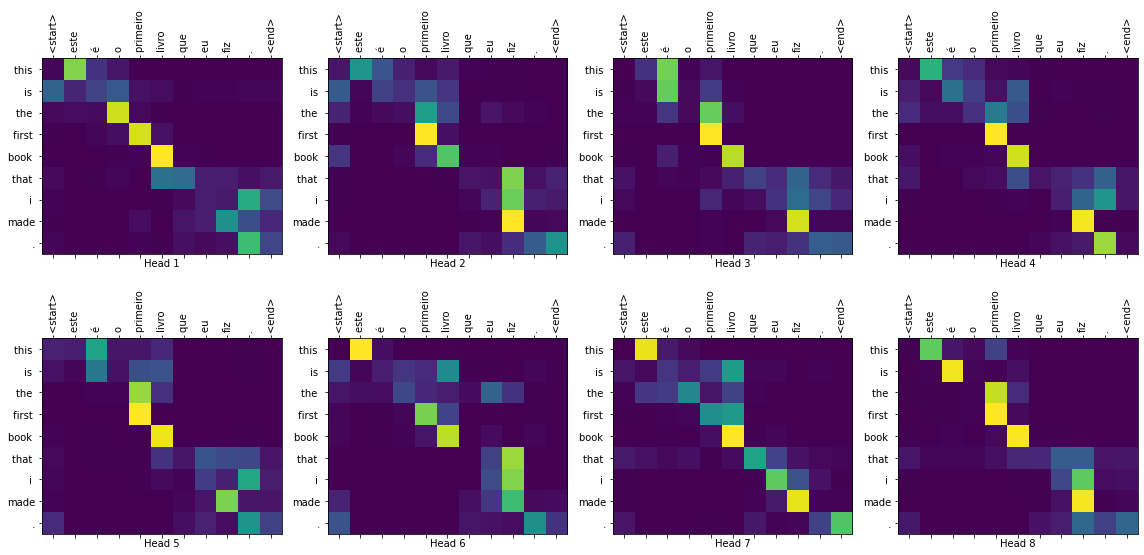

Real translation: this is the first book i've ever done.


In [60]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## 总结

在本教程中，您已经学习了位置编码，多头注意力，遮挡的重要性以及如何创建一个 transformer。

尝试使用一个不同的数据集来训练 transformer。您可也可以通过修改上述的超参数来创建基础 transformer 或者 transformer XL。您也可以使用这里定义的层来创建 [BERT](https://arxiv.org/abs/1810.04805) 并训练最先进的模型。此外，您可以实现 beam search 得到更好的预测。